In [1]:
import torch
import pandas as pd
from torch import nn, optim
from transformers import AutoModelForCausalLM, AutoTokenizer


In [2]:
model_name = "entropy/gpt2_zinc_87m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
generator = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/40.5k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/350M [00:00<?, ?B/s]

In [3]:
class Discriminator(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Outputs probability
        )

    def forward(self, x):
        # x: Batch of tokenized SMILES strings
        emb = self.embedding(x)  # Convert tokens to embeddings
        _, (hidden, _) = self.lstm(emb)  # Use the final hidden state
        output = self.fc(hidden[-1])  # Pass through FC layers
        return output

In [4]:
discriminator = Discriminator(vocab_size=len(tokenizer)) # Discriminator
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00001) # Dicriminator Optimizer
g_optimizer = optim.Adam(generator.parameters(), lr=0.005) # Generator Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss

# Load real data
real_data = pd.read_csv('Processed_Anti_Inflammatory_Compounds.csv')
real_data = real_data[real_data['anti_inflammatory'] == 1]
real_smiles = real_data['isosmiles'].tolist()

# Tokenize real SMILES
real_tokens = tokenizer(real_smiles, return_tensors="pt",
                        padding=True, truncation=True, max_length=100)['input_ids']


Epoch 1/200, Temperature: 1.00, D Loss: 1.3860697746276855, G Loss: 0.7118557691574097
Epoch 2/200, Temperature: 1.00, D Loss: 1.3856123685836792, G Loss: 0.7113873958587646
Epoch 3/200, Temperature: 0.99, D Loss: 1.3857917785644531, G Loss: 0.7102370858192444
Epoch 4/200, Temperature: 0.99, D Loss: 1.385608434677124, G Loss: 0.7094988822937012
Epoch 5/200, Temperature: 0.99, D Loss: 1.3867554664611816, G Loss: 0.7071763277053833
Epoch 6/200, Temperature: 0.98, D Loss: 1.3855737447738647, G Loss: 0.7073936462402344
Epoch 7/200, Temperature: 0.98, D Loss: 1.3851726055145264, G Loss: 0.706874668598175
Epoch 8/200, Temperature: 0.98, D Loss: 1.385484218597412, G Loss: 0.7055149674415588
Epoch 9/200, Temperature: 0.98, D Loss: 1.3858298063278198, G Loss: 0.704200029373169
Epoch 10/200, Temperature: 0.97, D Loss: 1.3853389024734497, G Loss: 0.703877329826355
Epoch 11/200, Temperature: 0.97, D Loss: 1.3846352100372314, G Loss: 0.7037935256958008
Epoch 12/200, Temperature: 0.97, D Loss: 1.385

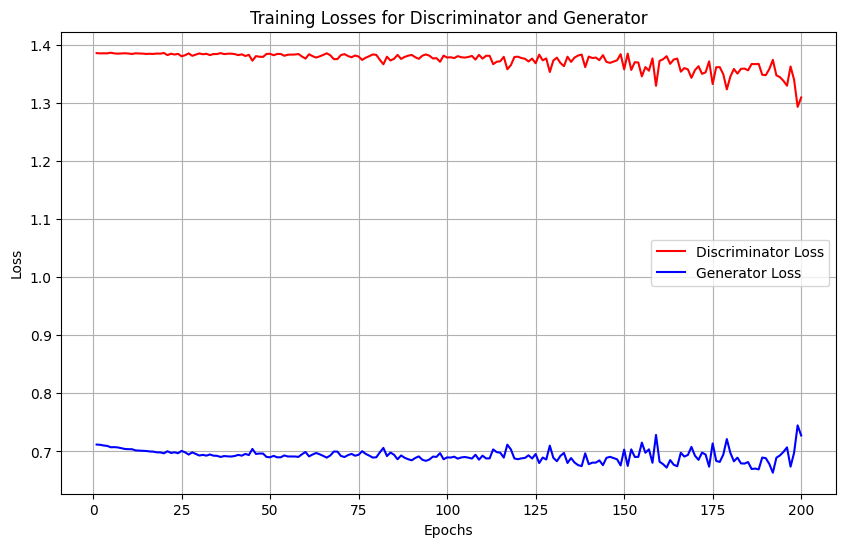

In [5]:
import torch
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your models to the GPU
generator.to(device)
discriminator.to(device)

# Training loop
epochs = 200

# Listes pour stocker les pertes du générateur et du discriminateur
d_losses = []
g_losses = []

for epoch in range(epochs):
    temperature = max(1.0 - 0.003 * epoch, 0.5)  # Gradually reduce temperature

    # 1. Generate SMILES with the generator
    inputs = torch.tensor([[tokenizer.bos_token_id]], device=device)  # Start token
    num_fake_samples = min(16, real_tokens.size(0))

    generated = generator.generate(
        inputs,
        do_sample=True,
        max_length=100,
        temperature=temperature,
        pad_token_id=tokenizer.pad_token_id,
        num_return_sequences=num_fake_samples
    )

    fake_smiles = tokenizer.batch_decode(generated, skip_special_tokens=True)

    # Tokenize fake SMILES
    fake_tokens = tokenizer(fake_smiles, return_tensors="pt", padding=True, truncation=True, max_length=100)['input_ids']
    fake_tokens = fake_tokens.to(device)  # Move fake tokens to GPU

    # Labels
    real_labels = torch.ones(real_tokens.size(0), 1, device=device)  # Move to GPU
    fake_labels = torch.zeros(fake_tokens.size(0), 1, device=device)  # Move to GPU

    # 2. Train Generator more often than Discriminator
    generator.train()
    g_optimizer.zero_grad()

    # Generator tries to fool the discriminator
    fake_preds = discriminator(fake_tokens)

    # Compute generator loss
    g_loss = criterion(fake_preds, real_labels[:fake_preds.size(0)])  # Match shapes

    g_loss.backward()
    g_optimizer.step()  # Update the generator

    # Train Generator again (double update)
    g_optimizer.zero_grad()
    fake_preds = discriminator(fake_tokens)  # Recompute predictions after first update
    g_loss = criterion(fake_preds, real_labels[:fake_preds.size(0)])  # Generator tries again to fool the discriminator
    g_loss.backward()
    g_optimizer.step()  # Update the generator again

    # 3. Train Discriminator
    discriminator.train()
    d_optimizer.zero_grad()  # Reset the gradients to zero

    # Forward pass for real and fake data
    real_tokens = real_tokens.to(device)  # Move real tokens to GPU
    real_preds = discriminator(real_tokens)
    fake_preds = discriminator(fake_tokens.detach())  # Detach fake tokens from the generator

    # Compute discriminator loss
    d_loss_real = criterion(real_preds, real_labels)
    d_loss_fake = criterion(fake_preds, fake_labels)
    d_loss = d_loss_real + d_loss_fake

    d_loss.backward()
    d_optimizer.step()  # Update the discriminator

    # Stocker les pertes pour chaque époque
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    # 4. Log Progress
    print(
        f"Epoch {epoch+1}/{epochs}, Temperature: {temperature:.2f}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}"
    )

# Tracer les courbes des pertes
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), d_losses, label="Discriminator Loss", color='r')
plt.plot(range(1, epochs + 1), g_losses, label="Generator Loss", color='b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Losses for Discriminator and Generator")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
'''Code pour sauvgarder le modèle entrainé'''
'''# Sauvegarder le générateur
torch.save(generator.state_dict(), "generator.pth")

# Sauvegarder le discriminateur
torch.save(discriminator.state_dict(), "discriminator.pth")
# Sauvegarder les modèles et optimisateurs
torch.save({
    'epoch': epoch + 1,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'g_optimizer_state_dict': g_optimizer.state_dict(),
    'd_optimizer_state_dict': d_optimizer.state_dict(),
    'g_loss': g_loss.item(),
    'd_loss': d_loss.item(),
    'd_losses': d_losses,
    'g_losses': g_losses,
}, "gan_checkpoint.pth")'''

'# Sauvegarder le générateur\ntorch.save(generator.state_dict(), "generator.pth")\n\n# Sauvegarder le discriminateur\ntorch.save(discriminator.state_dict(), "discriminator.pth")\n# Sauvegarder les modèles et optimisateurs\ntorch.save({\n    \'epoch\': epoch + 1,\n    \'generator_state_dict\': generator.state_dict(),\n    \'discriminator_state_dict\': discriminator.state_dict(),\n    \'g_optimizer_state_dict\': g_optimizer.state_dict(),\n    \'d_optimizer_state_dict\': d_optimizer.state_dict(),\n    \'g_loss\': g_loss.item(),\n    \'d_loss\': d_loss.item(),\n    \'d_losses\': d_losses,\n    \'g_losses\': g_losses,\n}, "gan_checkpoint.pth")'

In [7]:
'''# Recharger les modèles et optimisateurs
checkpoint = torch.load("gan_checkpoint.pth")
epoch = checkpoint['epoch']
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])

# Si tu veux reprendre l'entraînement à partir de l'état sauvegardé
g_losses = checkpoint['g_losses']
d_losses = checkpoint['d_losses']'''


'# Recharger les modèles et optimisateurs\ncheckpoint = torch.load("gan_checkpoint.pth")\nepoch = checkpoint[\'epoch\']\ngenerator.load_state_dict(checkpoint[\'generator_state_dict\'])\ndiscriminator.load_state_dict(checkpoint[\'discriminator_state_dict\'])\ng_optimizer.load_state_dict(checkpoint[\'g_optimizer_state_dict\'])\nd_optimizer.load_state_dict(checkpoint[\'d_optimizer_state_dict\'])\n\n# Si tu veux reprendre l\'entraînement à partir de l\'état sauvegardé\ng_losses = checkpoint[\'g_losses\']\nd_losses = checkpoint[\'d_losses\']'

In [8]:
generator.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(2707, 768)
    (wpe): Embedding(256, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=2707, bias=False)
)

In [9]:
# Paramètres
num_fake_samples = 100  # Nombre d'exemples à générer
max_length = 100  # Longueur maximale des séquences générées
temperature = 0.8  # Température à utiliser pendant la génération (contrôle la diversité)

# 1. Générer avec le générateur
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)  # Déplace le générateur sur le même appareil que l'entrée

# 1. Générer avec le générateur
inputs = torch.tensor([[tokenizer.bos_token_id]], device=device)  # Le token de début (Bos token)

generated = generator.generate(
    inputs,
    do_sample=True,  # Utilisation de l'échantillonnage pour la génération
    max_length=max_length,  # Longueur maximale des séquences
    temperature=temperature,  # Température pour l'échantillonnage
    pad_token_id=tokenizer.pad_token_id,  # Id du token de padding
    num_return_sequences=num_fake_samples  # Nombre de séquences à générer
)

# 2. Décoder les tokens générés en chaînes de texte SMILES
fake_smiles = tokenizer.batch_decode(generated, skip_special_tokens=True)

list_smiles = []
# 3. Afficher les SMILES générés
for i, smile in enumerate(fake_smiles):
    print(f"Generated SMILES {i+1}: {smile}")
    list_smiles.append(smile)


Generated SMILES 1: CN(C)Cc1ccc(C(=O)N(C)CCN(C)C/C=C/Cl)cc1
Generated SMILES 2: CC(C)(C)OC(=O)N1CC[C@@]2(C1)OCC[C@H]2Oc1cc2c(cc1[C@@H]1C(=O)Nc3ccccc31)OCO2
Generated SMILES 3: Cc1nc(C)c(C(=O)N2CCC[C@@H](CNC(=O)c3cnnn3C)C2)[nH]1
Generated SMILES 4: COc1cc(N2CCN(c3nnc([C@H]4CCC(=O)N4)n3CCCNC(C)=O)CC2)ccc1F
Generated SMILES 5: C[C@@H](OC(=O)CN1C(=O)c2ccccc2C1=O)C(=O)Nc1cc(F)ccc1F
Generated SMILES 6: COc1ccc(NCc2ccc(C#N)s2)nn1
Generated SMILES 7: CC(C)(C)C[C@H](O)CNC(=O)C(=O)c1c[nH]c2cc(F)ccc12
Generated SMILES 8: C[C@@H](NC(=O)c1ccccc1)C(=O)N[C@@H]1CN(C(=O)C2CC2)C[C@H]1O
Generated SMILES 9: C=CCN1C[C@@H](NC(=O)c2cc3c(nc2O)CCCC3)[C@@H](n2ccnn2)C1
Generated SMILES 10: CC(C)N(C)C(=O)C1CCN(c2nnc(C3CCCC3)n2C[C@@]2(O)CCC[C@H]2C)CC1
Generated SMILES 11: COc1ccc(C2=NO[C@H](CNC(=O)NCC[C@]3(C)C[C@]3(F)Cl)C2)cc1
Generated SMILES 12: CCc1nsc(N2CCCN(C(=O)Nc3ccc(F)cc3C(=O)OC)CC2)n1
Generated SMILES 13: COC(=O)c1c(F)cccc1S(=O)(=O)N1CC(C)(C)OC(C)(C)C1
Generated SMILES 14: Cc1nc(O)nc(O)c1CC(=O)N1C[C@H]2CC

In [10]:
!pip install rdkit
import numpy as np
from rdkit import Chem
from rdkit.Chem import QED
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.Chem.Fingerprints import FingerprintMols
from sklearn.metrics import pairwise_distances
import pandas as pd

# Fonction pour calculer la validité
def calculate_validity(molecules):
    valid_count = 0
    for mol in molecules:
        if Chem.MolFromSmiles(mol) is not None:
            valid_count += 1
    return valid_count / len(molecules)

# Fonction pour calculer l'originalité
def calculate_originality(generated_molecules, original_molecules):
    unique_molecules = set(generated_molecules) - set(original_molecules)
    return len(unique_molecules) / len(generated_molecules)

# Fonction pour calculer la diversité
def calculate_diversity(molecules):
    fps = [FingerprintMols.FingerprintMol(Chem.MolFromSmiles(mol)) for mol in molecules if Chem.MolFromSmiles(mol) is not None]
    pairwise_similarities = [TanimotoSimilarity(fps[i], fps[j]) for i in range(len(fps)) for j in range(i + 1, len(fps))]
    return 1 - np.mean(pairwise_similarities)

# Fonction pour calculer le drug-likeliness (via QED)
def calculate_drug_likeliness(molecules):
    druglike_count = 0
    for mol in molecules:
        mol_obj = Chem.MolFromSmiles(mol)
        if mol_obj is not None:
            qed_score = QED.qed(mol_obj)
            if qed_score > 0.5:  # Seuil arbitraire pour un drug-likeness raisonnable
                druglike_count += 1
    return druglike_count / len(molecules)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 56.8 MB/s eta 0:00:00


In [11]:
print("validité des molécules générées : ", calculate_validity(list_smiles))
print("originalité des molécules générées : ", calculate_originality(list_smiles, real_smiles))
print("diversite des molécules générées : ", calculate_diversity(list_smiles))
print("drug-likeliness des molécules générées : ", calculate_drug_likeliness(list_smiles))

validité des molécules générées :  1.0
originalité des molécules générées :  1.0
diversite des molécules générées :  0.6541304765050194
drug-likeliness des molécules générées :  0.95


In [12]:
# Etape 1: Tokenization des SMILES générés
# Vous avez déjà généré vos SMILES avec `generator.generate(...)`

# Tokenisation des SMILES générés pour les envoyer au discriminateur
fake_tokens = tokenizer(fake_smiles, return_tensors="pt", padding=True, truncation=True, max_length=100)['input_ids']

# Etape 2: Passer les tokens générés dans le discriminateur pour obtenir des prédictions
discriminator.eval()  # Passer le discriminateur en mode évaluation pour éviter le dropout
discriminator.to(device)  # Déplacez le discriminateur sur le même appareil que les tokens générés
with torch.no_grad():  # Pas de calcul de gradient pour la prédiction
    fake_preds = discriminator(fake_tokens.to(device))

X_result = pd.DataFrame({
    'isosmiles': fake_smiles
})
# Etape 3: Interpréter les résultats
# Les résultats sont des probabilités entre 0 et 1
for i, pred in enumerate(fake_preds):
    print(f"SMILES {i+1}: {fake_smiles[i]}")
    print(f"Prediction (Real/Fake probability): {pred.item():.4f}")


SMILES 1: CN(C)Cc1ccc(C(=O)N(C)CCN(C)C/C=C/Cl)cc1
Prediction (Real/Fake probability): 0.5275
SMILES 2: CC(C)(C)OC(=O)N1CC[C@@]2(C1)OCC[C@H]2Oc1cc2c(cc1[C@@H]1C(=O)Nc3ccccc31)OCO2
Prediction (Real/Fake probability): 0.5137
SMILES 3: Cc1nc(C)c(C(=O)N2CCC[C@@H](CNC(=O)c3cnnn3C)C2)[nH]1
Prediction (Real/Fake probability): 0.5271
SMILES 4: COc1cc(N2CCN(c3nnc([C@H]4CCC(=O)N4)n3CCCNC(C)=O)CC2)ccc1F
Prediction (Real/Fake probability): 0.5269
SMILES 5: C[C@@H](OC(=O)CN1C(=O)c2ccccc2C1=O)C(=O)Nc1cc(F)ccc1F
Prediction (Real/Fake probability): 0.5270
SMILES 6: COc1ccc(NCc2ccc(C#N)s2)nn1
Prediction (Real/Fake probability): 0.5277
SMILES 7: CC(C)(C)C[C@H](O)CNC(=O)C(=O)c1c[nH]c2cc(F)ccc12
Prediction (Real/Fake probability): 0.5272
SMILES 8: C[C@@H](NC(=O)c1ccccc1)C(=O)N[C@@H]1CN(C(=O)C2CC2)C[C@H]1O
Prediction (Real/Fake probability): 0.5249
SMILES 9: C=CCN1C[C@@H](NC(=O)c2cc3c(nc2O)CCCC3)[C@@H](n2ccnn2)C1
Prediction (Real/Fake probability): 0.5269
SMILES 10: CC(C)N(C)C(=O)C1CCN(c2nnc(C3CCCC3)n2C[C@@

In [13]:
!pip install rdkit

from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
from rdkit import Chem


# Function to calculate molecular descriptors from SMILES

def calculate_molecular_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        return None  # If the SMILES string is invalid

    descriptors = {}

    # Molecular weight (mw)
    descriptors["mw"] = Descriptors.MolWt(mol)

    # LogP (hydrophobicity, xlogp)
    descriptors["xlogp"] = Crippen.MolLogP(mol)

    # Polar surface area (polararea)
    descriptors["polararea"] = rdMolDescriptors.CalcTPSA(mol)

    # Number of rotatable bonds (rotbonds)
    descriptors["rotbonds"] = Descriptors.NumRotatableBonds(mol)

    # Hydrogen bond donors (hbonddonor)
    descriptors["hbonddonor"] = Descriptors.NumHDonors(mol)

    # Hydrogen bond acceptors (hbondacc)
    descriptors["hbondacc"] = Descriptors.NumHAcceptors(mol)

    return descriptors

In [14]:
def extract_descriptors(row):
    descriptors = calculate_molecular_descriptors(row['isosmiles'])
    if descriptors is not None:
        return pd.Series(descriptors)
    else:
        # Retourner None si la molécule est invalide
        return pd.Series({
            "mw": None,
            "xlogp": None,
            "polararea": None,
            "rotbonds": None,
            "hbonddonor": None,
            "hbondacc": None,
        })

# Appliquer la fonction à chaque ligne et concaténer les résultats avec X_result
descriptors_df = X_result.apply(extract_descriptors, axis=1)
X_result = pd.concat([X_result, descriptors_df], axis=1)

# Afficher les premières lignes pour vérification
X_result.head()

,isosmiles,mw,xlogp,polararea,rotbonds,hbonddonor,hbondacc
0,CN(C)Cc1ccc(C(=O)N(C)CCN(C)C/C=C/Cl)cc1,323.868,2.50450,26.79,8.0,0.0,3.0
1,CC(C)(C)OC(=O)N1CC[C@@]2(C1)OCC[C@H]2Oc1cc2c(c...,494.544,4.04660,95.56,3.0,1.0,7.0
2,Cc1nc(C)c(C(=O)N2CCC[C@@H](CNC(=O)c3cnnn3C)C2)...,345.407,0.43724,108.80,4.0,2.0,6.0
3,COc1cc(N2CCN(c3nnc([C@H]4CCC(=O)N4)n3CCCNC(C)=...,459.526,1.22970,104.62,8.0,2.0,8.0
4,C[C@@H](OC(=O)CN1C(=O)c2ccccc2C1=O)C(=O)Nc1cc(...,388.326,2.13120,92.78,5.0,1.0,5.0


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import joblib


# Step 1: Load the dataset
data = pd.read_csv("Processed_Anti_Inflammatory_Compounds.csv")

# Step 2: Separate features and target
X = data[["mw", "xlogp", "polararea", "rotbonds",
          "hbonddonor", "hbondacc"]]
y = data["anti_inflammatory"]

# Step 3: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 5a: Train Random Forest Classifier
# Train the optimized Random Forest model
optimized_rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

optimized_rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=300,
                       random_state=42)

In [16]:
X_test = X_result[["mw", "xlogp", "polararea", "rotbonds",
          "hbonddonor", "hbondacc"]]
probs = optimized_rf_model.predict_proba(X_test)[:, 1]
predictions = (probs >= 0.6).astype(int)
predictions

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])